In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.0.3
0.5.2
4.1.2


In [2]:
!pwd

/home/cho/AIFFEL_quest_rs/Exploration/Ex05


In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab(dicpath='/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '로', 29: '정말', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '어', 35: '재밌', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '기', 42: '에서', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '인', 53: '연기', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '해', 66: '1', 67: '스토리', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '아니', 73: '생각', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '보다', 87: '알', 88: '만들', 89: '내용', 90: '볼', 91: '감독', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '

In [8]:
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '로': 28, '정말': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '어': 34, '재밌': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '기': 41, '에서': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '인': 52, '연기': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '해': 65, '1': 66, '스토리': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '아니': 72, '생각': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '보다': 86, '알': 87, '만들': 88, '내용': 89, '볼': 90, '감독': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 1

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 일반적으로 95%의 신뢰구간을 가정하므로, 최대 길이를 (평균 + 2.5*표준편차)로 한다면  
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 표준편차 :  12.844062009473816
pad_sequences maxlen :  48
전체 문장의 0.9548682034821515%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

2025-02-06 15:31:01.049188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 15:31:01.076902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 15:31:01.077767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 15:31:01.631436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(146182, 48)


4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

=> 실험을 위해 LSTM, CNN, BiLSTM 모델을 설계 /  Trainable Parameter의 수를 비슷하게 조정하여 유사한 표현력을 가지는 상황을 조성

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [12]:
#test셋과 비슷한 비중으로 validation set 46182건 분리
print('테스트셋 크기 : ' + str(x_test.shape))
x_val = x_train[:46182]   
y_val = y_train[:46182]

# validation set을 제외한 나머지 100000건
partial_x_train = x_train[46182:]  
partial_y_train = y_train[46182:]
print(partial_x_train.shape)
print(partial_y_train.shape)

테스트셋 크기 : (49157, 48)
(100000, 48)
(100000,)


In [13]:
# model_1 설계 : LSTM
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(8))
model_1.add(tf.keras.layers.Dense(8,activation='relu'))
model_1.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160881 (628.44 KB)
Trainable params: 160881 (628.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-02-06 15:31:02.373813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-06 15:31:02.374080: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
#model_2 설계 : 1D CNN 기반
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())  # 중요한 특징만 추출
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1296      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 161441 (630.63 KB)
Trainable params: 161441 (630.63 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [21]:
#model_3 설계 : BiLSTM
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))  # BiLSTM
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                1600      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 161745 (631.82 KB)
Trainable params: 161745 (631.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


5) 모델 훈련 개시

In [16]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history_1 = model_1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 4s 16ms/step - loss: 0.5205 - accuracy: 0.7732 - val_loss: 0.3741 - val_accuracy: 0.8419
Epoch 2/20
196/196 [==============================] - 3s 16ms/step - loss: 0.3474 - accuracy: 0.8543 - val_loss: 0.3495 - val_accuracy: 0.8494
Epoch 3/20
196/196 [==============================] - 3s 15ms/step - loss: 0.3180 - accuracy: 0.8693 - val_loss: 0.3479 - val_accuracy: 0.8494
Epoch 4/20
196/196 [==============================] - 3s 14ms/step - loss: 0.3027 - accuracy: 0.8764 - val_loss: 0.3528 - val_accuracy: 0.8488
Epoch 5/20
196/196 [==============================] - 3s 15ms/step - loss: 0.2918 - accuracy: 0.8820 - val_loss: 0.3522 - val_accuracy: 0.8507
Epoch 6/20
196/196 [==============================] - 3s 15ms/step - loss: 0.2811 - accuracy: 0.8867 - val_loss: 0.3585 - val_accuracy: 0.8484
Epoch 7/20
196/196 [==============================] - 3s 14ms/step - loss: 0.2716 - accuracy: 0.8920 - val_loss: 0.3609 - val_accuracy: 0.8508

In [17]:
result_1 = model_1.evaluate(x_test,  y_test, verbose=2)

print(result_1)

1537/1537 - 2s - loss: 0.5147 - accuracy: 0.8325 - 2s/epoch - 1ms/step
[0.5147085189819336, 0.8325162529945374]


In [18]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_2 = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 2s 6ms/step - loss: 0.5321 - accuracy: 0.7535 - val_loss: 0.3725 - val_accuracy: 0.8347
Epoch 2/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3424 - accuracy: 0.8534 - val_loss: 0.3460 - val_accuracy: 0.8502
Epoch 3/20
196/196 [==============================] - 1s 5ms/step - loss: 0.2998 - accuracy: 0.8772 - val_loss: 0.3431 - val_accuracy: 0.8523
Epoch 4/20
196/196 [==============================] - 1s 5ms/step - loss: 0.2707 - accuracy: 0.8913 - val_loss: 0.3479 - val_accuracy: 0.8531
Epoch 5/20
196/196 [==============================] - 1s 5ms/step - loss: 0.2446 - accuracy: 0.9038 - val_loss: 0.3572 - val_accuracy: 0.8506
Epoch 6/20
196/196 [==============================] - 1s 5ms/step - loss: 0.2207 - accuracy: 0.9160 - val_loss: 0.3698 - val_accuracy: 0.8505
Epoch 7/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1970 - accuracy: 0.9282 - val_loss: 0.3862 - val_accuracy: 0.8482
Epoch 

In [19]:
result_2 = model_2.evaluate(x_test,  y_test, verbose=2)

print(result_2)

1537/1537 - 1s - loss: 0.8298 - accuracy: 0.8175 - 920ms/epoch - 599us/step
[0.8298082947731018, 0.8175030946731567]


In [22]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_3 = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 6s 22ms/step - loss: 0.5109 - accuracy: 0.7690 - val_loss: 0.3674 - val_accuracy: 0.8437
Epoch 2/20
196/196 [==============================] - 4s 20ms/step - loss: 0.3431 - accuracy: 0.8542 - val_loss: 0.3491 - val_accuracy: 0.8501
Epoch 3/20
196/196 [==============================] - 4s 20ms/step - loss: 0.3171 - accuracy: 0.8668 - val_loss: 0.3496 - val_accuracy: 0.8483
Epoch 4/20
196/196 [==============================] - 4s 19ms/step - loss: 0.3036 - accuracy: 0.8732 - val_loss: 0.3503 - val_accuracy: 0.8503
Epoch 5/20
196/196 [==============================] - 4s 19ms/step - loss: 0.2910 - accuracy: 0.8791 - val_loss: 0.3548 - val_accuracy: 0.8505
Epoch 6/20
196/196 [==============================] - 4s 20ms/step - loss: 0.2794 - accuracy: 0.8844 - val_loss: 0.3565 - val_accuracy: 0.8508
Epoch 7/20
196/196 [==============================] - 4s 20ms/step - loss: 0.2680 - accuracy: 0.8902 - val_loss: 0.3634 - val_accuracy: 0.8468

In [23]:
result_3 = model_3.evaluate(x_test,  y_test, verbose=2)

print(result_3)

1537/1537 - 3s - loss: 0.5412 - accuracy: 0.8293 - 3s/epoch - 2ms/step
[0.5412485599517822, 0.8293427228927612]


6) Loss, Accuracy 그래프 시각화

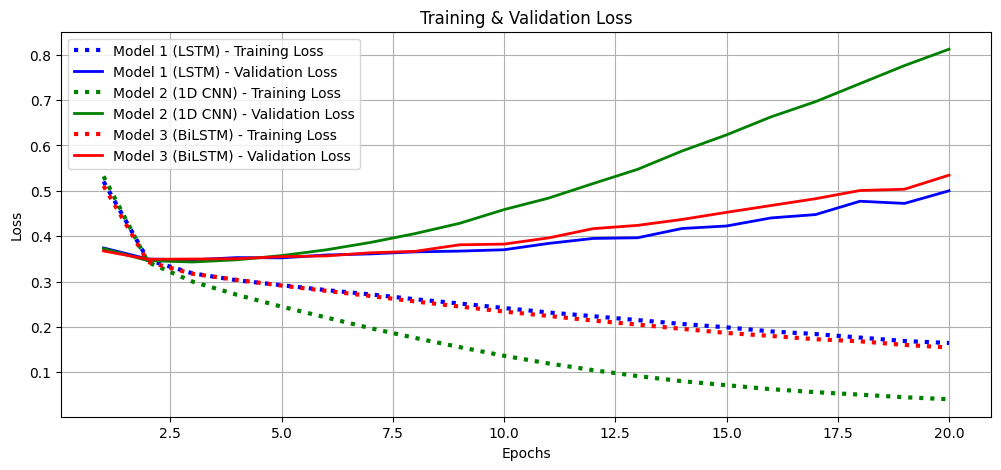

In [39]:
import matplotlib.pyplot as plt

# 모델별 history 데이터
histories = [history_1.history, history_2.history, history_3.history]
model_labels = ["Model 1 (LSTM)", "Model 2 (1D CNN)", "Model 3 (BiLSTM)"]
colors = ['b', 'g', 'r']

# 그래프 그리기
epochs = range(1, len(histories[0]['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
for i, (history, color) in enumerate(zip(histories, colors)):
    plt.plot(epochs, history['loss'], label=f"{model_labels[i]} - Training Loss", linestyle='dotted', linewidth=3, color=color)
    plt.plot(epochs, history['val_loss'], label=f"{model_labels[i]} - Validation Loss", linestyle='solid', linewidth=2, color=color)
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

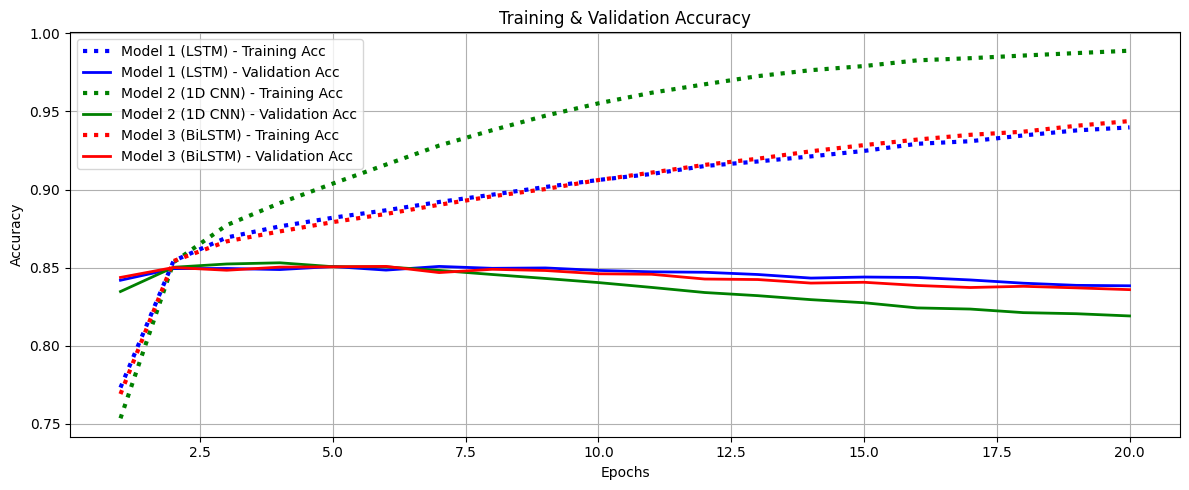

In [40]:
# Accuracy 그래프
plt.figure(figsize=(12, 5))
for i, (history, color) in enumerate(zip(histories, colors)):
    plt.plot(epochs, history['accuracy'], label=f"{model_labels[i]} - Training Acc", linestyle='dotted', linewidth=3, color=color)
    plt.plot(epochs, history['val_accuracy'], label=f"{model_labels[i]} - Validation Acc", linestyle='solid', linewidth=2, color=color)
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

7) 학습된 Embedding 레이어 분석

In [41]:
embedding_layer_model_1 = model_1.layers[0]
weights_model_1 = embedding_layer_model_1.get_weights()[0]
print(weights_model_1.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [42]:
word2vec_file_path_model_1 = './data/word2vec_model_1.txt'
f = open(word2vec_file_path_model_1, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [44]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_model_1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_model_1, binary=False)
vector = word_vectors_model_1['사랑']
vector

array([-0.08446749,  0.09946074, -0.09681027, -0.07232139, -0.12123157,
        0.11327253,  0.03340477,  0.00709907,  0.0830873 , -0.03071211,
       -0.05499986,  0.01299704,  0.12349446,  0.08891355, -0.09711676,
        0.10880877], dtype=float32)

In [45]:
word_vectors_model_1.similar_by_word("사랑")

[('눈물', 0.9337810277938843),
 ('ㅠㅠㅠㅠㅠ', 0.9255380630493164),
 ('명작', 0.9129354953765869),
 ('니슨', 0.9087029695510864),
 ('굿', 0.9078201055526733),
 ('울음', 0.90004563331604),
 ('시원', 0.8997013568878174),
 ('비범', 0.8993362188339233),
 ('재', 0.8985065221786499),
 ('미워할', 0.8977938890457153)]

In [46]:
embedding_layer_model_2 = model_2.layers[0]
weights_model_2 = embedding_layer_model_2.get_weights()[0]
print(weights_model_2.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [47]:
word2vec_file_path_model_2 = './data/word2vec_model_2.txt'
f = open(word2vec_file_path_model_2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [49]:
word_vectors_model_2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_model_2, binary=False)
vector = word_vectors_model_2['사랑']
vector

array([-0.01778495,  0.0871995 ,  0.04445443,  0.0411691 , -0.02553311,
        0.0793968 , -0.02920903, -0.0452236 , -0.14312764,  0.05445446,
       -0.02145064, -0.1047283 , -0.12710549, -0.02760238,  0.04324585,
       -0.13560961], dtype=float32)

In [50]:
word_vectors_model_2.similar_by_word("사랑")

[('완성', 0.8292607665061951),
 ('달콤', 0.7986701726913452),
 ('수작', 0.7924852967262268),
 ('life', 0.7794241309165955),
 ('이장우', 0.768907368183136),
 ('못지않', 0.7672232389450073),
 ('을려나', 0.7654765248298645),
 ('생김', 0.7630656361579895),
 ('타워', 0.762414276599884),
 ('명작', 0.7606608867645264)]

In [51]:
embedding_layer_model_3 = model_3.layers[0]
weights_model_3 = embedding_layer_model_3.get_weights()[0]
print(weights_model_3.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [52]:
word2vec_file_path_model_3 = './data/word2vec_model_3.txt'
f = open(word2vec_file_path_model_3, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [53]:
word_vectors_model_3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_model_3, binary=False)
vector = word_vectors_model_3['사랑']
vector

array([-0.02320533,  0.1361819 , -0.02475747, -0.06173516,  0.04962579,
        0.12962857, -0.109253  , -0.05936567,  0.14434314,  0.09515089,
        0.10476906, -0.04681761, -0.03981877, -0.05769587, -0.08710919,
        0.11886739], dtype=float32)

In [55]:
word_vectors_model_3.similar_by_word("사랑")

[('높여', 0.9319850206375122),
 ('깊', 0.9160745739936829),
 ('맛보', 0.9128435850143433),
 ('가져야', 0.9101733565330505),
 ('모델', 0.9049026966094971),
 ('텐', 0.904303252696991),
 ('풀어낼', 0.9020294547080994),
 ('괜찮', 0.9008151888847351),
 ('초등', 0.8981117606163025),
 ('8', 0.8978073596954346)]

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [58]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_model_path = './data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_model_path)
vector = word_vectors.wv['사랑']
vector

array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [75]:
from gensim.models import Word2Vec
word_vectors = Word2Vec.load(word2vec_model_path).wv
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.key_to_index:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [76]:
from tensorflow.keras.initializers import Constant

#model_2 방식으로 embedding_Matrix만 추가하여 실험
model_Word2Vec_2 = tf.keras.Sequential()
model_Word2Vec_2.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_Word2Vec_2.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
model_Word2Vec_2.add(tf.keras.layers.GlobalMaxPooling1D())  # 중요한 특징만 추출
model_Word2Vec_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_Word2Vec_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_Word2Vec_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 48, 100)           1000000   
                                                                 
 conv1d_6 (Conv1D)           (None, 44, 16)            8016      
                                                                 
 global_max_pooling1d_4 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1008161 (3.85 MB)
Trainable params: 1008161 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [77]:
# 학습의 진행
model_Word2Vec_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_4 = model_Word2Vec_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 4s 19ms/step - loss: 0.5984 - accuracy: 0.6802 - val_loss: 0.5231 - val_accuracy: 0.7400
Epoch 2/20
196/196 [==============================] - 3s 17ms/step - loss: 0.4858 - accuracy: 0.7679 - val_loss: 0.4656 - val_accuracy: 0.7810
Epoch 3/20
196/196 [==============================] - 3s 18ms/step - loss: 0.4290 - accuracy: 0.8034 - val_loss: 0.4266 - val_accuracy: 0.8037
Epoch 4/20
196/196 [==============================] - 3s 17ms/step - loss: 0.3878 - accuracy: 0.8273 - val_loss: 0.4030 - val_accuracy: 0.8179
Epoch 5/20
196/196 [==============================] - 3s 17ms/step - loss: 0.3569 - accuracy: 0.8434 - val_loss: 0.3873 - val_accuracy: 0.8266
Epoch 6/20
196/196 [==============================] - 3s 17ms/step - loss: 0.3318 - accuracy: 0.8559 - val_loss: 0.3809 - val_accuracy: 0.8319
Epoch 7/20
196/196 [==============================] - 3s 17ms/step - loss: 0.3118 - accuracy: 0.8660 - val_loss: 0.3787 - val_accuracy: 0.8352

In [78]:
# 테스트셋을 통한 모델 평가
results = model_Word2Vec_2.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.5145 - accuracy: 0.8279 - 1s/epoch - 890us/step
[0.5144701600074768, 0.8279390335083008]


In [79]:
from gensim.models import Word2Vec
word_vectors = Word2Vec.load(word2vec_model_path).wv
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.key_to_index:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [80]:
# model_1 방식으로 embedding_Matrix만 추가하여 실험
model_Word2Vec_1 = tf.keras.Sequential()
model_Word2Vec_1.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_Word2Vec_1.add(tf.keras.layers.LSTM(8))
model_Word2Vec_1.add(tf.keras.layers.Dense(8,activation='relu'))
model_Word2Vec_1.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model_Word2Vec_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 48, 100)           1000000   
                                                                 
 lstm_4 (LSTM)               (None, 8)                 3488      
                                                                 
 dense_18 (Dense)            (None, 8)                 72        
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1003569 (3.83 MB)
Trainable params: 1003569 (3.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
# 학습의 진행
model_Word2Vec_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
            

history_5 = model_Word2Vec_1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 7s 30ms/step - loss: 0.6266 - accuracy: 0.6576 - val_loss: 0.5143 - val_accuracy: 0.7578
Epoch 2/20
196/196 [==============================] - 5s 28ms/step - loss: 0.4524 - accuracy: 0.7923 - val_loss: 0.4112 - val_accuracy: 0.8146
Epoch 3/20
196/196 [==============================] - 6s 28ms/step - loss: 0.3839 - accuracy: 0.8319 - val_loss: 0.3818 - val_accuracy: 0.8317
Epoch 4/20
196/196 [==============================] - 5s 28ms/step - loss: 0.3504 - accuracy: 0.8496 - val_loss: 0.3705 - val_accuracy: 0.8388
Epoch 5/20
196/196 [==============================] - 5s 27ms/step - loss: 0.3290 - accuracy: 0.8617 - val_loss: 0.3630 - val_accuracy: 0.8421
Epoch 6/20
196/196 [==============================] - 5s 28ms/step - loss: 0.3119 - accuracy: 0.8709 - val_loss: 0.3616 - val_accuracy: 0.8449
Epoch 7/20
196/196 [==============================] - 6s 28ms/step - loss: 0.2981 - accuracy: 0.8778 - val_loss: 0.3618 - val_accuracy: 0.8439

In [82]:
# 테스트셋을 통한 모델 평가
results = model_Word2Vec_1.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4308 - accuracy: 0.8395 - 3s/epoch - 2ms/step
[0.4307940900325775, 0.8395141959190369]
